In [1]:
# PCA 16 components Real Data Electricity

# PCA anomaly detection SCADAS

PCA used for anomaly detection <br>

Normal and attack real data<br>


In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages = 3 

2022-10-13 22:03:45.671253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 22:03:45.671275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# assign number of components
n_comp = 16

In [4]:
def label_marker(row):
    if isinstance(row[label_name], str) and 'Natural' in row[label_name]:
        return 0
    if isinstance(row[label_name], str) and 'Attack' in row[label_name]:
        return 1
    return 

In [5]:
path = './gas/'
path_figures = './figures/'
label_name = 'result'
#path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_normal = path +'Normal.csv'
path_attack = path + 'Attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
attack_df = pd.read_csv(path_attack)  

normal_df[label_name] = normal_df.apply(label_marker, axis=1)
attack_df[label_name] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df[label_name].to_numpy() 
attack_label = attack_df[label_name].to_numpy() 

print(len(normal_label))
print(len(attack_label))

61156
35863


In [6]:
# Delete marker column 
normal_df.drop([label_name], axis=1, inplace=True)
attack_df.drop([label_name], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (61156, 26)
attack shape (35863, 26)


In [8]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [9]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(35863, 26)
(61156, 26)


In [10]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = np.zeros(len(X_test_norm))

In [11]:
#x_train = traffic_np_norm[...,np.newaxis]
#x_combine = combine_np_norm[...,np.newaxis]
#x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", X_train.shape)
print("Test Traffic Test input shape: ", X_test.shape, )

Normal Traffic Training input shape:  (48924, 26)
Test Traffic Test input shape:  (24464, 26)


In [12]:
# Apply PCA to input

model_input_PCA = PCA(n_components=None, random_state=123, 
                      svd_solver='arpack')
X_transform_input = model_input_PCA.fit_transform(X_train)



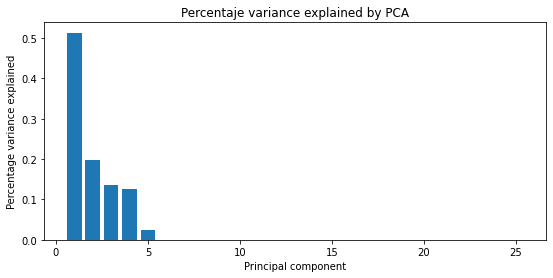

In [13]:
fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.bar(
   x = np.arange(model_input_PCA.n_components_) + 1,
   height = model_input_PCA.explained_variance_ratio_
)

ax.set_title('Percentaje variance explained by PCA')
ax.set_xlabel('Principal component')
ax.set_ylabel('Percentage variance explained');
plt.show()

------------------------------------------
Cummulated variance explained
------------------------------------------
[0.51339838 0.71211374 0.84852755 0.97498036 0.99885005 0.99951766
 0.99995325 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


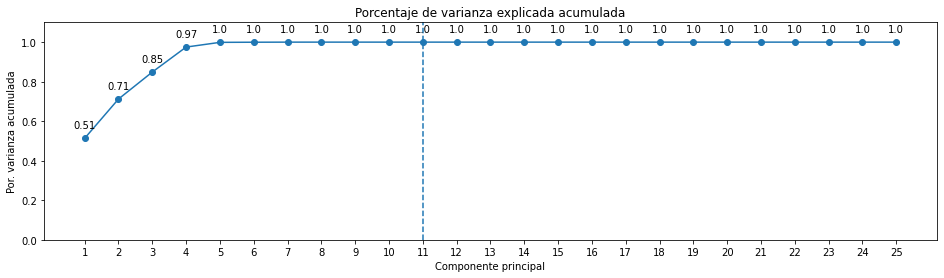

In [14]:
# Cummulated variance explained
# ==============================================================================
prop_varianza_acum = model_input_PCA.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Cummulated variance explained')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(
    np.arange(model_input_PCA.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(model_input_PCA.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.axvline(x=11, linestyle = '--')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(model_input_PCA.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');



In [15]:
# Projection reconstruction
# ==============================================================================
X_train_df = pd.DataFrame(X_train)

projections = model_input_PCA.transform(X_train_df)
reconstruction = model_input_PCA.inverse_transform(X=projections)

reconstruccion = pd.DataFrame(
                    reconstruction,
                    columns = X_train_df.columns,
                    index   = X_train_df.index,
)

print('------------------')
print('Original values')
print('------------------')
display(reconstruccion.head(3))

print('')
print('---------------------')
print('Reconstruction values')
print('---------------------')
display(X_train_df.head(3))

------------------
Original values
------------------


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-8.396065e-17,1.229666e-16,0.717647,7.906872e-17,1.0,5.953540e-16,3.791266e-16,-2.519452e-16,1.0,7.651234e-16,...,-4.342346e-16,1.513977e-16,6.671767e-17,1.0,1.0,0.000000e+00,0.000000e+00,-1.524086e-17,8.788716e-16,0.356227
1,-1.140542e-16,-1.344250e-17,0.717647,2.378629e-16,1.0,4.949827e-16,4.060086e-16,-2.143612e-16,1.0,8.118833e-16,...,-4.696702e-16,6.854374e-17,1.329074e-16,1.0,1.0,0.000000e+00,2.081668e-17,2.201479e-16,7.835488e-16,0.143659
2,-8.708153e-18,4.640740e-16,0.717647,-3.180154e-16,1.0,8.463444e-16,3.119049e-16,-3.459287e-16,1.0,6.481946e-16,...,-3.456235e-16,3.585839e-16,-9.879782e-17,1.0,1.0,-6.938894e-17,-4.857226e-17,-6.038590e-16,1.117238e-15,0.887779



---------------------
Reconstruction values
---------------------


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.717647,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.578947e-17,0.356227
1,0.0,0.0,0.717647,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.578947e-17,0.143659
2,0.0,0.0,0.717647,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.578947e-17,0.887779


In [16]:
def reconstruccion_error(X, n_components, X_new=None):
    '''
    Function that calculates reconstruction error of two dataframes
    
    Parameters
    ----------
    
    X (data.frame): Dataframe to train the PCA
    X_new (data.frame): Dataframe to apply reconstruction
    n_components: number of components for the PCA application
    
    Returns
    -------
    
    Reconstruction dataframe 
    Numpy array with reconstruction error
    
    '''
    
    if X_new is None:
        X_new = X
    
    # Entrenamiento modelo PCA con escalado de los datos
    pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components,
                                random_state=124))
    pca_pipeline.fit(X=X)
    
    # Proyectar los datos
    proyecciones = pca_pipeline.transform(X_new)
    
    # Reconstrucción
    reconstruccion = pca_pipeline.inverse_transform(proyecciones)
    reconstruccion = pd.DataFrame(
                        reconstruccion,
                        columns = X_new.columns,
                        index   = X_new.index
                    )
    # RMSE
    error_reconstruccion = reconstruccion - X_new
    error_reconstruccion = error_reconstruccion**2
    error_reconstruccion = error_reconstruccion.mean(axis=1)
    
    print(f"Reconstruction with a PCA of {n_components} components")
    
    return reconstruccion, error_reconstruccion

In [17]:
# Reconstruction error with n components
X_test_attack_df = pd.DataFrame(X_test_attack)
X_train_df       = pd.DataFrame(X_train)
X_train_df       = X_train_df.head(50000)
rec_normal, error_normal = reconstruccion_error(X=X_train_df, 
                                                n_components = n_comp)

rec_attack, error_attack = reconstruccion_error(X=X_train_df, 
                           n_components =n_comp, 
                           X_new=X_test_attack_df)

Reconstruction with a PCA of 16 components
Reconstruction with a PCA of 16 components


In [18]:
# Let's do a PCA reconstruction again

X_test_norm = X_test[0:len(X_test_attack)]   # We balance both labels by equaling vectors
X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = np.zeros(len(X_test_norm))
X_test_df = pd.DataFrame(X_test)

reconstruction_test, error_test = reconstruccion_error(X = X_test_norm, n_components = n_comp,
                                                       X_new = X_test_df)

Reconstruction with a PCA of 16 components


In [19]:
df_results = pd.DataFrame({
                    'error_reconstruction' : error_test,
                    'type'                 : y_test})
df_results[df_results['type']==0]

,error_reconstruction,type
0,2.295971e-32,0.0
1,3.555138e-33,0.0
2,3.073516e-33,0.0
3,1.345145e-32,0.0
4,2.234295e-32,0.0
...,...,...
12227,5.696467e-33,0.0
12228,3.610228e-33,0.0
12229,4.386083e-33,0.0
12230,3.616023e-33,0.0


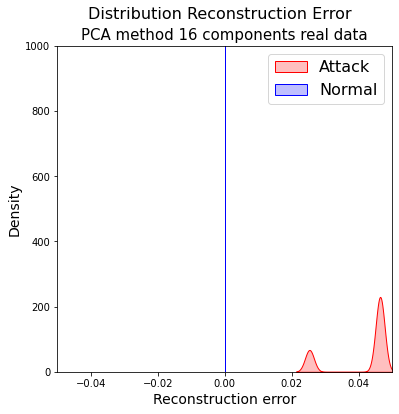

In [20]:
# === Paper Figure ===
# Distribución reconstruction error 

df_results = pd.DataFrame({
                    'error_reconstruction' : error_test,
                    'type'                 : y_test})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.kdeplot(
    df_results[df_results['type']==1].error_reconstruction,
    fill    = True,
    ax      = ax,
    label   = 'Attack',
    color   = 'red'
)
sns.kdeplot(
    df_results[df_results['type']==0].error_reconstruction,
    fill    = True,
    ax      = ax,
    label   = 'Normal',
    color   = 'blue'
)

#sns.rugplot(error_reconstruccion,  ax=ax, color='black')
plt.suptitle('Distribution Reconstruction Error',y=0.97, 
            fontsize=16)
ax.set_title('PCA method '+str(n_comp)+' components real data', fontsize=15)
ax.set_xlabel('Reconstruction error', fontsize = 14);
ax.set_ylabel('Density',fontsize=14);
ax.set_xlim(-0.05,0.050)
ax.set_ylim(0,1000)
plt.legend( fontsize=16)
plt.savefig(path_figures+'PCA_anomalies_'+str(n_comp)+'_rea_gas.png', dpi=600)
plt.show()

In [21]:
# Let's do a PCA reconstruction again

X_test_norm = X_test[0:len(X_test_attack)]   # We balance both labels by equaling vectors
X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = np.zeros(len(X_test_norm))
X_test_df = pd.DataFrame(X_test)

reconstruction_test, error_test = reconstruccion_error(X = X_test_norm, n_components = n_comp,
                                                       X_new = X_test_df)

Reconstruction with a PCA of 16 components


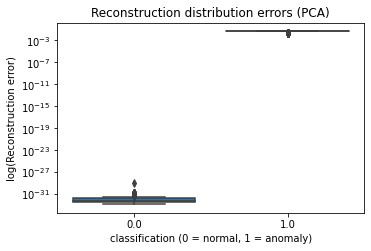

In [22]:
# test result

df_results = pd.DataFrame({
                    'error_reconstruction' : error_test,
                    'type'                 : y_test})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
sns.boxplot(
    x     = 'type',
    y     = 'error_reconstruction',
    data  = df_results,
    ax    = ax
)
ax.set_yscale("log")
ax.set_title('Reconstruction distribution errors (PCA)')
ax.set_ylabel('log(Reconstruction error)')
ax.set_xlabel('classification (0 = normal, 1 = anomaly)');

In [23]:
df_results['type'].value_counts()

0.0    12232
1.0    12232
Name: type, dtype: int64

In [24]:
rmse_error = df_results.error_reconstruction.to_numpy()
error_threshold = np.median(rmse_error)
print('error threshold >>>', error_threshold)

anomalies = (rmse_error > error_threshold)
np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

error threshold >>> 0.012651216111178103
total length vector anomalies :  24464
Number of anomalies :  12232
total length of y_test vector 24464
total lenght of attacks in y_test vector 12232


In [25]:
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12232
         1.0       1.00      1.00      1.00     12232

    accuracy                           1.00     24464
   macro avg       1.00      1.00      1.00     24464
weighted avg       1.00      1.00      1.00     24464



In [26]:
#==================

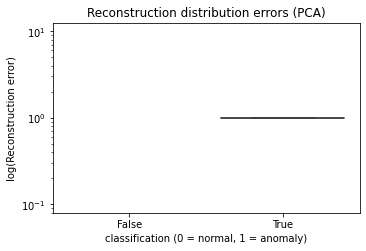

In [27]:
df_results = pd.DataFrame({
                    'anomaly' : anomalies,
                    'label'   : y_test
                })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
sns.boxplot(
    x     = 'anomaly',
    y     = 'label',
    data  = df_results,
    #color = "white",
    palette = 'tab10',
    ax    = ax
)
ax.set_yscale("log")
ax.set_title('Reconstruction distribution errors (PCA)')
ax.set_ylabel('log(Reconstruction error)')
ax.set_xlabel('classification (0 = normal, 1 = anomaly)');

In [28]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

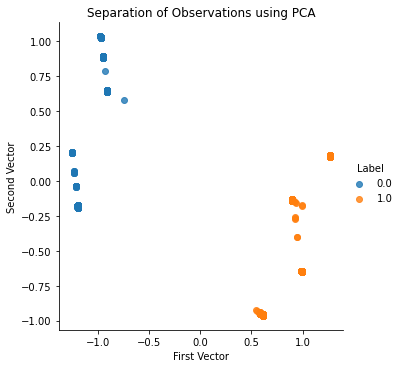

In [29]:
n_components = 2
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_test_PCA = pca.fit_transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(X_test_PCA_inverse)

scatterPlot(X_test_PCA, pd.Series(y_test) , "PCA")

In [30]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [31]:
#anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
#preds = plotResults(y_test, anomalyScoresPCA, True)

In [32]:
import session_info
session_info.show(html=False)

-----
keras               2.7.0
matplotlib          3.5.0
numpy               1.23.1
pandas              1.3.4
seaborn             0.11.2
session_info        1.0.0
sklearn             1.0.1
tensorflow          2.7.0
-----
IPython             7.29.0
jupyter_client      7.0.6
jupyter_core        4.9.1
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.15.0-48-generic-x86_64-with-glibc2.17
-----
Session information updated at 2022-10-13 22:04


In [33]:
#===============================0

In [34]:
#EOF